### Приложение знакомств

Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Был разработан новый алгоритм для поиска наиболее подходящих анкет. 

Необходимо оценить, правда ли, что новый алгоритм улучшил качество сервиса. 

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import pingouin as pg
import statsmodels.api as sm

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline


### Предварительный анализ данных

In [2]:
df_dating = pd.read_csv('dating_data.csv')

In [3]:
df_dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df_dating.shape

(14514, 4)

In [5]:
df_dating.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [6]:
df_dating.groupby('group', as_index=False).agg({'is_match':['count', 'sum', 'mean']})

group is_match                
           count   sum      mean
0     0     4792   934  0.194908
1     1     9722  3909  0.402078

In [7]:
df_dating.groupby('group', as_index=False).agg({'user_id_1':'nunique', 'user_id_2':'nunique'})

,group,user_id_1,user_id_2
0,0,501,501
1,1,499,499


In [8]:
gr_00 = set(df_dating.query('group == 0').user_id_1)
gr_01 = set(df_dating.query('group == 1').user_id_1)

gr_00.intersection(gr_01)

set()

In [9]:
gr_10 = set(df_dating.query('group == 0').user_id_2)
gr_11 = set(df_dating.query('group == 1').user_id_2)

gr_10.intersection(gr_11)

set()

### Выводы (предварительный анализ данных):  
1. В данных не повторяются пары. 
2. Пользователи встречаются в двух колонках с айдишниками. 
3. Количество юзеров в каждой группе почти равны
4. Число пар больше в экспериментальной группе 
5. Буду считать, что колонка user_id_1 - пользователь, который поставил лайк первым, а user_id_2 поставил лайк вторым
6. Пересечений между группами нет

### Метрики

Первое что приходит в голову - это конверсия (число мэтчей, которое приходится на 1 пользователя деленное на число свайпов, но в нашем случе на общее число созданных пар).  
Буду подсчитывать количество мэтчей, когда юзер стоит в первой колонке, потом когда во второй, затем складывать.  
Второе, о чем я подумала - общее соотношение числа свайпов к числу метчей в двух разных группах

### Конверсия

In [10]:
df_dating.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [11]:
df_match_1 = df_dating.groupby(['group', 'user_id_1'], as_index=False).agg({'is_match': ['sum', 'count']})

In [12]:
df_match_1.droplevel(level=1, axis=1)
df_match_1.columns = ['group', 'user_id', 'match_1', 'all_swipe_1']

In [13]:
df_match_2 = df_dating.groupby(['group', 'user_id_2'], as_index=False).agg({'is_match': ['sum', 'count']})

In [14]:
df_match_2.columns = ['group', 'user_id', 'match_2', 'all_swipe_2']

In [15]:
df_match = df_match_1.merge(df_match_2, on=['group', 'user_id'], how='inner')

In [16]:
df_match.head()

,group,user_id,match_1,all_swipe_1,match_2,all_swipe_2
0,0,4,2,9,1,8
1,0,10,3,6,3,14
2,0,12,1,12,1,8
3,0,14,0,8,0,8
4,0,15,3,20,3,12


In [17]:
df_match['CTR'] = (df_match.match_1 + df_match.match_2) / (df_match.all_swipe_1 + df_match.all_swipe_2) 

In [18]:
df_match['all_swipe'] = df_match.all_swipe_1 + df_match.all_swipe_2
df_match['match'] = df_match.match_1 + df_match.match_2

In [19]:
df_match = df_match.drop(['match_1', 'all_swipe_1', 'match_2', 'all_swipe_2'], axis=1)

In [20]:
df_match 

,group,user_id,CTR,all_swipe,match
0,0,4,0.176471,17,3
1,0,10,0.300000,20,6
2,0,12,0.100000,20,2
3,0,14,0.000000,16,0
4,0,15,0.187500,32,6
...,...,...,...,...,...
995,1,987,0.414634,41,17
996,1,992,0.400000,35,14
997,1,993,0.439024,41,18
998,1,998,0.500000,36,18


### Визуализация CTR

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


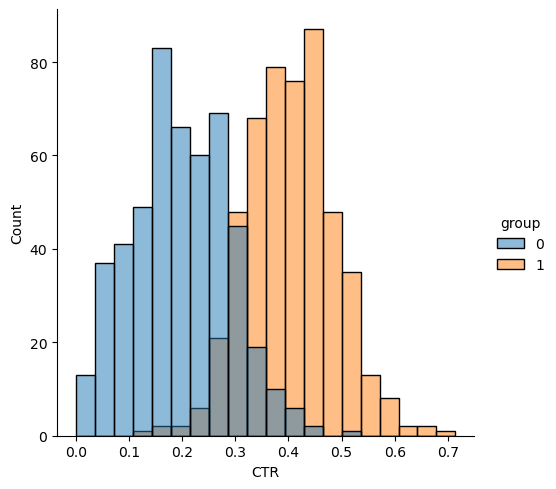

In [21]:
sns.displot(df_match, x='CTR', hue='group', bins=20)

Text(0, 0.5, 'CTR')

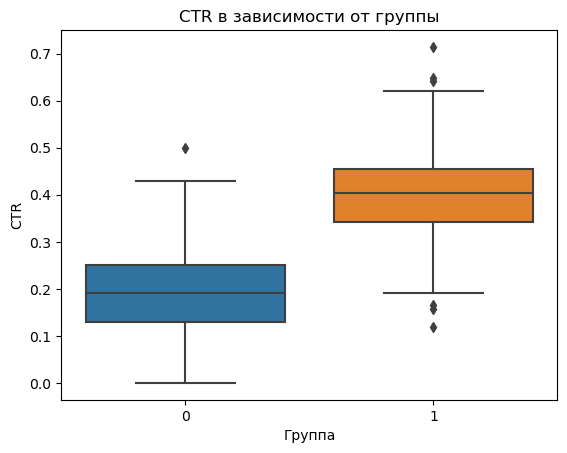

In [22]:
sns.boxplot(x = 'group', y = 'CTR', data = df_match)
plt.title('CTR в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('CTR')

Text(0, 0.5, 'CTR')

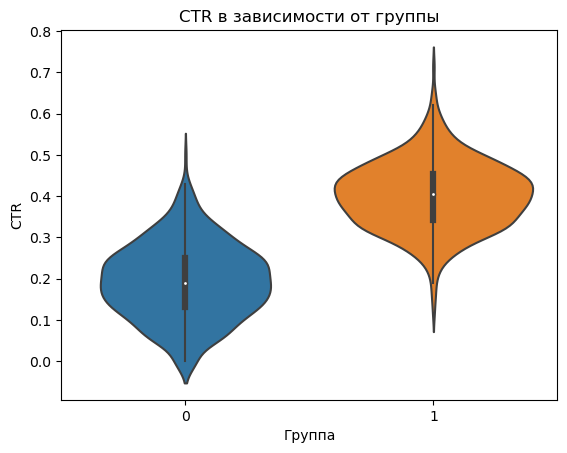

In [23]:
sns.violinplot(x = 'group', y = 'CTR', data = df_match)
plt.title('CTR в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('CTR')

In [24]:
pg.normality(df_match.query("group == 0"), method='normaltest').round(3)

,W,pval,normal
group,NaN,NaN,False
user_id,260.965,0.000,False
CTR,3.142,0.208,True
all_swipe,5.214,0.074,True
match,26.414,0.000,False


In [25]:
pg.normality(df_match.query("group == 1"), method='normaltest').round(3)

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1808: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


,W,pval,normal
group,NaN,NaN,False
user_id,387.328,0.000,False
CTR,4.217,0.121,True
all_swipe,0.320,0.852,True
match,8.029,0.018,False


In [26]:
ss.levene(df_match.query("group == 0").CTR, df_match.query("group == 1").CTR)

LeveneResult(statistic=7.013821816267975, pvalue=0.008215929686873376)

### Вывод (анализ распределений)
Тесты показали, что распределение CTR является нормальным, но требование гомогенности дисперсий не выполняется. Необходимо использовать t-тест Уэлча для сравнения средних значений выборок.


### Как изменился CTR 
#### Гипотезы  
$H_0$ - средние значения CTR равны в экспериментальной и контрольной группах  
$H_1$ - средние значения CTR в группах различаются 

In [27]:
group_control = np.array(df_match.query("group == 0").CTR)
group_experiment = np.array(df_match.query("group == 1").CTR)

In [28]:
pg.ttest(group_control, group_experiment, correction='auto')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-38.242658,987.842388,two-sided,4.415154e-197,"[-0.22, -0.2]",2.418173,3.171e+193,1.0


### Вывод (t-тест Уэлча)
t-тест Уэлча показал, что средние значения в экспериментальной и контрольной выборках статистически значимо различаются, следовательно с высокой долей вероятности мы можем утверждать, что новый алгоритм улучшил качество сервиса

### Как изменяется соотношение метчей и не-метчей
#### Гипотезы  
$H_0$ - соотношение метчей и не-метчей равны в экспериментальной и контрольной группах  
$H_1$ - соотношение метчей и не-метчей в группах различаются 

In [29]:
table = pd.crosstab(df_dating.group, df_dating.is_match)
table

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [30]:
expected, observed, stats = pg.chi2_independence(df_dating, x='group',
                                                 y='is_match')

In [31]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


### Вывод 
Соотношение статистически значимо отличается в контрольной и экспериментальной группе (в эксперментальной группе соотношение метчей к не-метчей выше)

### Как изменилось число анкет, которые видит 1 пользователь
#### Гипотезы  
$H_0$ - средние значения числа анкет, которые видит 1 пользователь, равны в экспериментальной и контрольной группах  
$H_1$ - средние значения числа анкет, которые видит 1 пользователь, в группах различаются 

Text(0, 0.5, 'Количество свайпов')

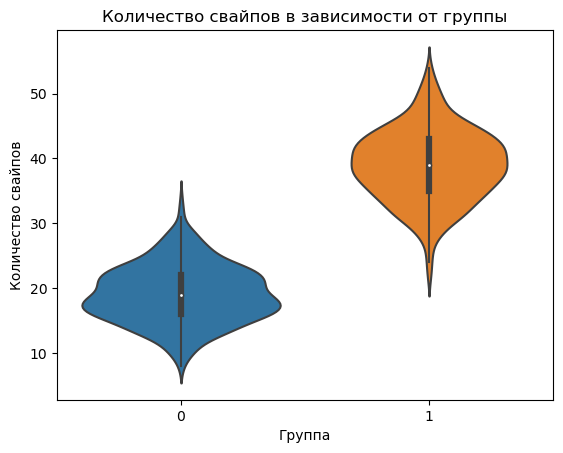

In [35]:
sns.violinplot(x = 'group', y = 'all_swipe', data = df_match)
plt.title('Количество свайпов в зависимости от группы')
plt.xlabel('Группа')
plt.ylabel('Количество свайпов')

In [36]:
group_control = np.array(df_match.query("group == 0").CTR)
group_experiment = np.array(df_match.query("group == 1").CTR)

In [37]:
pg.ttest(group_control, group_experiment, correction='auto')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-38.242658,987.842388,two-sided,4.415154e-197,"[-0.22, -0.2]",2.418173,3.171e+193,1.0


### Вывод (t-тест)
t-тест показал, что средние значения в экспериментальной и контрольной выборках статистически значимо различаются, следовательно с высокой долей вероятности мы можем утверждать, что новый алгоритм улучшил качество сервиса


### Общий вывод:
Проведенный эксперимент показал, что с высокой долей вероятности новый алгоритм оказал положительное влияние на поиск наиболее подходящих анкет. Раскатываем алгоритм на всех пользователей. 